<a href="https://colab.research.google.com/github/gigihArmy/chatbot_lstm_DL/blob/main/tes_lstm_chatbot.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Import Library

In [1]:
import json
import numpy as np
import pandas as pd
import tensorflow as tf
import nltk
import random
import string
import matplotlib.pyplot as plt

from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.models import Model
from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Flatten, Dense, GlobalMaxPool1D
from tensorflow.keras.layers import Input, Embedding, LSTM, Dropout, Bidirectional, Conv1D, MaxPooling1D, GRU

## Load Dataset

In [2]:
!wget https://raw.githubusercontent.com/gigihArmy/chatbot_lstm_DL/refs/heads/main/dataset_dl.json -O data.json

# Membaca file JSON
import json

with open('data.json') as f:
    data = json.load(f)
    print(data)

--2025-01-08 11:19:36--  https://raw.githubusercontent.com/gigihArmy/chatbot_lstm_DL/refs/heads/main/dataset_dl.json
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 161883 (158K) [text/plain]
Saving to: ‘data.json’

data.json           100%[===================>] 158.09K  --.-KB/s    in 0.05s   

2025-01-08 11:19:36 (3.38 MB/s) - ‘data.json’ saved [161883/161883]

{'intens': [{'tag': 'salam', 'patterns': ['Halo', 'Hai', 'Selamat pagi', 'Selamat siang', 'Apa kabar?', 'Halo cui', 'Halo rek', 'Halo bro apa kabar', 'Selamat sore', 'Selamat malam', 'Apa kabar?', 'Gimana kabarmu?', 'Apa yang bisa saya bantu?', 'Apa yang sedang kamu lakukan?', 'Selamat datang', 'Apa yang sedang terjadi?', 'Hallo', 'Hey', 'Hi, apa kabar?', 'Apa kabar hari ini?', 'Kamu baik-baik saja?

In [3]:
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [4]:
#Mendapatkan semua data dalam list
tags = []
inputs = []
responses = {}
words = []
classes = []
documents = []
ignore_words = ['?', '!']

for intent in data['intens']:
  responses[intent['tag']] = intent['responses']
  for lines in intent['patterns']:
    inputs.append(lines)
    tags.append(intent['tag'])
    for pattern in intent['patterns']:
      w = nltk.word_tokenize(pattern)
      words.extend(w)
      documents.append((w, intent['tag']))

      if intent['tag'] not in classes:
        classes.append(intent['tag'])

In [5]:
#Split dataset
X_train, X_test, y_train, y_test = train_test_split(inputs, tags, test_size=0.2, random_state=20)
train_data = pd.DataFrame({"patterns": X_train, "tags": y_train})
test_data = pd.DataFrame({"patterns": X_test, "tags": y_test})

In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1514 entries, 0 to 1513
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   patterns  1514 non-null   object
 1   tags      1514 non-null   object
dtypes: object(2)
memory usage: 23.8+ KB


In [7]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 379 entries, 0 to 378
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   patterns  379 non-null    object
 1   tags      379 non-null    object
dtypes: object(2)
memory usage: 6.0+ KB


In [8]:
train_data.describe()

,patterns,tags
count,1514,1514
unique,1503,44
top,Hubungan dialektika sama materialisme apa ya?,madilog_penerapan
freq,2,82


In [9]:
test_data.describe()

,patterns,tags
count,379,379
unique,378,44
top,Apa pandangan Tan Malaka tentang nasionalisme?,madilog_penerapan
freq,2,21


In [10]:
train_data.head()

,patterns,tags
0,Kenapa Tan Malaka suka dibahas di dunia akademik?,tan_malaka_relevansi_saat_ini
1,Bagaimana Tan Malaka mengkritik kapitalisme?,tan_malaka_kritik_terhadap_kapitalisme
2,"Kalau liat sesuatu dari sudut pandang nyata, i...",materialisme_contoh
3,Tan Malaka beneran nggak ada pas kemerdekaan?,pencarian_tan_malaka
4,Komunis banget ya Tan Malaka?,tan_malaka_komunis


In [11]:
test_data.head()

,patterns,tags
0,Tan Malaka itu bagaimana dalam memperjuangkan ...,tan_malaka_perjuangan
1,Bagaimana cerita akhir hidup Tan Malaka?,tan_malaka_kematian
2,Buku Madilog Tan Malaka tuh masih kepake nggak...,tan_malaka_relevansi_saat_ini
3,Apa peran Tan Malaka dalam pembentukan negara ...,tan_malaka_perjuangan
4,Ada tips nggak biar gue makin logis?,logika_contoh


Text Preprocessing

In [12]:
train_data['patterns'] = train_data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
train_data['patterns'] = train_data['patterns'].apply(lambda wrd: ''.join(wrd))
test_data['patterns'] = test_data['patterns'].apply(lambda wrd:[ltrs.lower() for ltrs in wrd if ltrs not in string.punctuation])
test_data['patterns'] = test_data['patterns'].apply(lambda wrd: ''.join(wrd))

In [13]:
#inisialisasi lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
  tokens = nltk.word_tokenize(text)
  lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
  lemmatized_text = ' '.join(lemmatized_tokens)
  return lemmatized_text

train_data['patterns'] = train_data['patterns'].apply(lemmatize_text)
test_data['patterns'] = test_data['patterns'].apply(lemmatize_text)

In [14]:
#Tokenisasi Data
tokenizer = Tokenizer(num_words=2000)
tokenizer.fit_on_texts(train_data['patterns'])

X_train = tokenizer.texts_to_sequences(train_data['patterns'])
X_test = tokenizer.texts_to_sequences(test_data['patterns'])

In [15]:
#Apply Padding
max_sequence_length = max(len(seq) for seq in X_train + X_test)
X_train = pad_sequences(X_train, maxlen=max_sequence_length)
X_test = pad_sequences(X_test, maxlen=max_sequence_length)

In [16]:
#Kombinasi tag dari train_data dan test_data
all_tags = list(set(train_data['tags']) | set(test_data['tags']))

le = LabelEncoder()
le.fit(all_tags)

y_train = le.transform(train_data['tags'])
y_test = le.transform(test_data['tags'])

In [17]:
train_dataset = (X_train, y_train)
test_dataset = (X_test, y_test)

## Download Embedding Bahasa Indonesia

In [18]:
import requests

# URL FastText embeddings bahasa Indonesia
url = "https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.id.300.vec.gz"

# Nama file untuk menyimpan hasil unduhan
output_file = "cc.id.300.vec.gz"

print("Downloading FastText embeddings for Indonesian...")
response = requests.get(url, stream=True)

with open(output_file, "wb") as file:
    for chunk in response.iter_content(chunk_size=1024):
        if chunk:
            file.write(chunk)

print(f"FastText embeddings downloaded and saved as {output_file}")


FastText embeddings downloaded and saved as cc.id.300.vec.gz


In [19]:
import gzip
import shutil

# File yang diunduh
compressed_file = "cc.id.300.vec.gz"
extracted_file = "cc.id.300.vec"

print("Extracting FastText embeddings...")
with gzip.open(compressed_file, "rb") as f_in:
    with open(extracted_file, "wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

print(f"File extracted and saved as {extracted_file}")


Extracting FastText embeddings...
File extracted and saved as cc.id.300.vec


In [20]:
# Melihat beberapa baris pertama dari file
with open("cc.id.300.vec", "r", encoding="utf-8") as file:
    for i, line in enumerate(file):
        print(line.strip())
        if i >= 5:  # Cetak 5 baris pertama
            break


2000000 300
, 0.0183 -0.0404 -0.0395 0.1229 0.0618 0.0565 -0.0779 -0.0407 -0.0291 0.0576 0.0657 -0.0430 -0.0021 -0.0458 -0.0132 0.0089 -0.0113 0.0401 0.0180 -0.0375 0.0785 0.0343 -0.0198 -0.0528 -0.0672 0.0253 0.0055 -0.0146 -0.3152 -0.0715 0.1358 0.0030 -0.0072 -0.0426 -0.0688 0.0144 -0.0659 0.0574 0.0455 0.0627 0.0093 -0.0405 -0.0428 -0.0014 -0.0373 -0.0410 -0.1958 -0.0225 -0.0270 -0.0086 -0.0368 -0.0131 -0.0343 0.3139 -0.0489 0.0225 -0.1792 -0.0570 0.1698 -0.0275 0.0008 0.0186 -0.0361 0.0036 0.0356 -0.0258 0.0205 -0.0130 0.0609 -0.0564 0.0818 -0.0085 0.0117 -0.0182 -0.0567 0.0169 -0.0649 0.0420 -0.0049 -0.0469 -0.0438 0.0168 0.0049 -0.0019 -0.0086 -0.0399 0.0553 0.1233 -0.0834 0.0228 0.0380 0.0788 0.1494 0.0223 -0.0073 -1.0348 -0.0141 -0.0839 0.0066 -0.0121 -0.0218 0.0307 0.0266 0.0165 -0.0789 -0.0476 -0.0421 0.0650 0.0017 -0.0051 0.0138 0.1108 0.0192 0.0312 0.0101 0.0154 -0.0734 0.0402 0.0107 -0.0304 0.0464 0.0296 0.0664 -0.0754 0.0293 -0.0405 -0.0370 -0.0597 -0.0431 -0.0367 -0.014

In [21]:
# Path ke file hasil ekstraksi
fasttext_file_path = "cc.id.300.vec"

# Dimensi embedding FastText
embedding_dim = 300

# Membaca file FastText embeddings
embeddings_index = {}
with open(fasttext_file_path, "r", encoding="utf-8") as f:
    for line in f:
        values = line.strip().split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype="float32")
        embeddings_index[word] = coefs

print(f"Loaded {len(embeddings_index)} word vectors from FastText.")

Loaded 2000000 word vectors from FastText.


In [22]:
# Membuat matriks embedding untuk kata-kata dalam tokenizer
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector  # Gunakan vector FastText jika tersedia


## Arsitektur Model

In [28]:
#Model
regularization = regularizers.l2(0.01)

#Dropout
dropout_rate = 0.5

#Input layer
input_layer = Input(shape=(max_sequence_length,))

#Embedding layer
#embedding_size = 10
#x = Embedding(len(tokenizer.word_index) + 1, embedding_size)(input_layer)

# Embedding layer dengan pretrained FastText
embedding_layer = Embedding(
    input_dim=len(tokenizer.word_index) + 1,
    output_dim=embedding_dim,
    weights=[embedding_matrix],  # Gunakan pretrained FastText weights
    input_length=max_sequence_length,
    trainable=False  # Set False agar tidak melatih ulang embedding
)(input_layer)

#LSTM layer
lstm_units = 16
x = Bidirectional(LSTM(lstm_units, return_sequences=True))(embedding_layer)

#Gru layer
#ru_units = 32
#x = Bidirectional(GRU(gru_units, return_sequences=True))(x)

#Flatten layer
x = Flatten()(x)

#Dense layer
dense_units = 50
x = Dense(dense_units, activation='relu')(x)
x = Dropout(dropout_rate)(x)

#Output layer
num_classes = len(classes)
x = Dense(num_classes, activation='softmax')(x)
model = Model(inputs=input_layer, outputs=x)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 13)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 13, 300)             │         311,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, 13, 32)              │          40,576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 416)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 50)                  │          20,850 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 44)                  │           2,244 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 374,770 (1.43 MB)

 Trainable params: 63,670 (248.71 KB)

 Non-trainable params: 311,100 (1.19 MB)

In [29]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.7):
      print("\nValidasi Akurasi telah mencapai 70%, stop training")

      self.model.stop_training = True

In [30]:
cb = myCallback()
learning_rate = 0.0001
optimizer = Adam(learning_rate=learning_rate)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [31]:
#Train model
history = model.fit(train_dataset[0], train_dataset[1], batch_size=32, epochs=250, callbacks=[cb], validation_data=test_dataset)

Epoch 1/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 7s 42ms/step - accuracy: 0.0227 - loss: 3.7869 - val_accuracy: 0.0369 - val_loss: 3.7800
Epoch 2/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.0327 - loss: 3.7789 - val_accuracy: 0.0580 - val_loss: 3.7729
Epoch 3/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - accuracy: 0.0567 - loss: 3.7714 - val_accuracy: 0.0712 - val_loss: 3.7639
Epoch 4/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.0515 - loss: 3.7605 - val_accuracy: 0.0897 - val_loss: 3.7517
Epoch 5/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.0600 - loss: 3.7498 - val_accuracy: 0.0739 - val_loss: 3.7347
Epoch 6/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - accuracy: 0.0584 - loss: 3.7308 - val_accuracy: 0.0660 - val_loss: 3.7092
Epoch 7/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - accuracy: 0.0672 - loss: 3.7012 - val_accuracy: 0.0712 - val_loss: 3.6747
Epoch 8/250
48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.0647 - loss: 3.6804 - val_accuracy: 0.

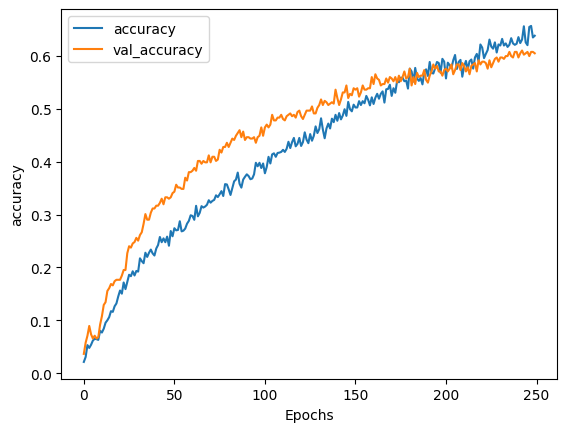

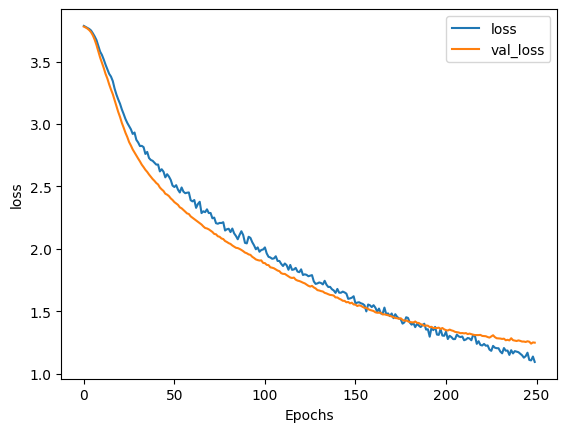

In [32]:
#Vis akurasi dan loss
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Uji Coba Chatbot

In [33]:
#chat input
while True:
  texts = []
  prediction_input = input("Anda: ")

  #hapus punk dan lowercase
  prediction_input = [letters.lower() for letters in prediction_input if letters not in string.punctuation]
  prediction_input = ''.join(prediction_input)
  texts.append(prediction_input)

  #tokenisasi dan padding
  prediction_input = tokenizer.texts_to_sequences(texts)
  prediction_input = np.array(prediction_input).reshape(-1)
  prediction_input = pad_sequences([prediction_input], maxlen=max_sequence_length)

  output = model.predict(prediction_input)
  output = output.argmax()

  # Menghitung confidence level (probabilitas tertinggi dari prediksi)
  confidence = output.max()  # Ambil probabilitas tertinggi

  # Tentukan ambang batas confidence
  threshold = 0.6  # Anda bisa menyesuaikan nilai threshold ini
  if confidence < threshold:
      response_tag = "unknown"
      print("ChatBot: Maaf, saya tidak tahu jawabannya.")
  else:
      # Jika confidence lebih tinggi dari threshold, gunakan tag yang diprediksi
      response_tag = le.inverse_transform([output])[0]
      print("ChatBot: ", random.choice(responses[response_tag]))

  #response_tag = le.inverse_transform([output])[0]
  #print("ChatBot: ", random.choice(responses[response_tag]))
  if response_tag == "perpisahan":
    break

Anda: halo
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 379ms/step
ChatBot:  Selamat datang Malakan! Aku akan membantu menjawab pertanyaan seputar Tan Malaka disini. Kamu mau nanya apa?
Anda: aku bukan malakan
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
ChatBot:  Malakan untuk menyapa kamu yang berkunjung kesini untuk membahas seputar tokoh pahalawan Indonesia yaitu Tan Malaka.
Anda: oke siapa tan malaka bro?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
ChatBot:  Lenin dikenal sebagai tokoh yang mendorong revolusi melalui teori dan praktek. Ia percaya bahwa perubahan besar hanya bisa dicapai melalui perjuangan kolektif yang terorganisir.
Anda: aku bertanya tentang tan malaka
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
ChatBot:  Tan Malaka meninggal secara tragis pada tahun 1949, dan hingga kini banyak hal seputar kematiannya masih menjadi kontroversi.
Anda: siapa john lenon
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
ChatBot:  Malakan adalah sebutan bagi yang mengunjungi kesini untuk menanyakan tentang Tokoh Pahlawan Tan Malak

In [35]:
model.save("chatbot_lstm_model.keras")